In [1]:
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 120
import pandas as pd
import numpy as np

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


#### Define DNN

In [3]:
# Parameters
learning_rate = 0.1
alpha = 0.0001
dropout = 0.2
momentum = 0.99
num_steps = 5000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 128
n_hidden_2 = 128
num_input = 28*28
num_classes = 10

In [4]:
# tf Graph input
X = tf.placeholder(tf.float64, [None, num_input])
Y = tf.placeholder(tf.float64, [None, num_classes])
training = tf.placeholder(tf.bool, name="training")

In [5]:
# Create model
def neural_net(x):
    drop1 = tf.layers.dropout(x, dropout, training=True)
    layer1 = tf.layers.dense(drop1,
                             n_hidden_1,
                             activation=None,
                             use_bias=True,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=num_input**-0.5),
                             kernel_regularizer=tf.contrib.layers.l1_regularizer(alpha))
    bn1 = tf.layers.batch_normalization(layer1, training=True, momentum=momentum)
    act1 = tf.nn.sigmoid(bn1)
    drop2 = tf.layers.dropout(act1, dropout, training=True)
    layer2 = tf.layers.dense(drop2,
                             n_hidden_2,
                             activation=None,
                             use_bias=True,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=n_hidden_1**-0.5),
                             kernel_regularizer=tf.contrib.layers.l1_regularizer(alpha))
    bn2 = tf.layers.batch_normalization(layer2, training=True, momentum=momentum)
    act2 = tf.nn.sigmoid(bn2)
    drop3 = tf.layers.dropout(act2, dropout, training=True)
    out_layer = tf.layers.dense(drop3,
                                num_classes,
                                activation=tf.nn.sigmoid,
                                use_bias=True,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=n_hidden_2**-0.5),
                                kernel_regularizer=tf.contrib.layers.l1_regularizer(alpha))
    return out_layer

# Construct model
logits = neural_net(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Evaluate model
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1)), tf.float32))

#### Training

In [6]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    metrics = {
        'train_loss':[],
        'train_acc':[],
        'test_loss':[],
        'test_acc':[]
    }
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, training: True})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mnist.train.images, Y: mnist.train.labels, training: False})
            print("Step " + str(step) + " Train loss: %0.5f, Train acc: %0.5f" % (loss, acc))
            metrics['train_loss'].append(loss)
            metrics['train_acc'].append(acc)
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mnist.test.images, Y: mnist.test.labels, training: False})
            print("Step " + str(step) + " Test loss: %0.5f, Test acc: %0.5f" % (loss, acc))
            metrics['test_loss'].append(loss)
            metrics['test_acc'].append(acc)

    print("Optimization Finished!")

Step 1 Train loss: 2.29313, Train acc: 0.14933
Step 1 Test loss: 2.29470, Test acc: 0.14140
Step 100 Train loss: 1.91510, Train acc: 0.78298
Step 100 Test loss: 1.91415, Test acc: 0.79500
Step 200 Train loss: 1.79481, Train acc: 0.82998
Step 200 Test loss: 1.79101, Test acc: 0.83540
Step 300 Train loss: 1.73108, Train acc: 0.84284
Step 300 Test loss: 1.72816, Test acc: 0.85180
Step 400 Train loss: 1.69418, Train acc: 0.84813
Step 400 Test loss: 1.69190, Test acc: 0.85230
Step 500 Train loss: 1.66686, Train acc: 0.85876
Step 500 Test loss: 1.66472, Test acc: 0.86280
Step 600 Train loss: 1.64855, Train acc: 0.86507
Step 600 Test loss: 1.64592, Test acc: 0.86750
Step 700 Train loss: 1.63515, Train acc: 0.86736
Step 700 Test loss: 1.63072, Test acc: 0.87630
Step 800 Train loss: 1.62409, Train acc: 0.87082
Step 800 Test loss: 1.62264, Test acc: 0.87590
Step 900 Train loss: 1.61275, Train acc: 0.87540
Step 900 Test loss: 1.61056, Test acc: 0.88140
Step 1000 Train loss: 1.60584, Train acc: 0.

Text(0,0.5,'Loss')

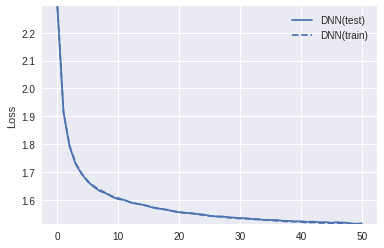

In [7]:
snc = sns.color_palette()

plt.plot(metrics['test_loss'], color=snc[0])
plt.plot(metrics['train_loss'], color=snc[0], ls='--')
plt.ylim(min(metrics['test_loss']), max(metrics['test_loss']))
plt.legend(['DNN(test)', 'DNN(train)'])
plt.ylabel('Loss')